# Greedy Reindeer - A Starter code to the Traveling Santa Problem
### Using a greedy algorithm to solve the problem

Prime cities are taken into account

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import norm
from collections import Counter
from time import time
from matplotlib import collections  as mc

sns.set_style('whitegrid')

## Loading Data

In [2]:
df = pd.read_csv("./data/cities.csv")

In [3]:
df.head()

,CityId,X,Y
0,0,316.836739,2202.340707
1,1,4377.405972,336.602082
2,2,3454.158198,2820.053011
3,3,4688.099298,2935.898056
4,4,1010.696952,3236.750989


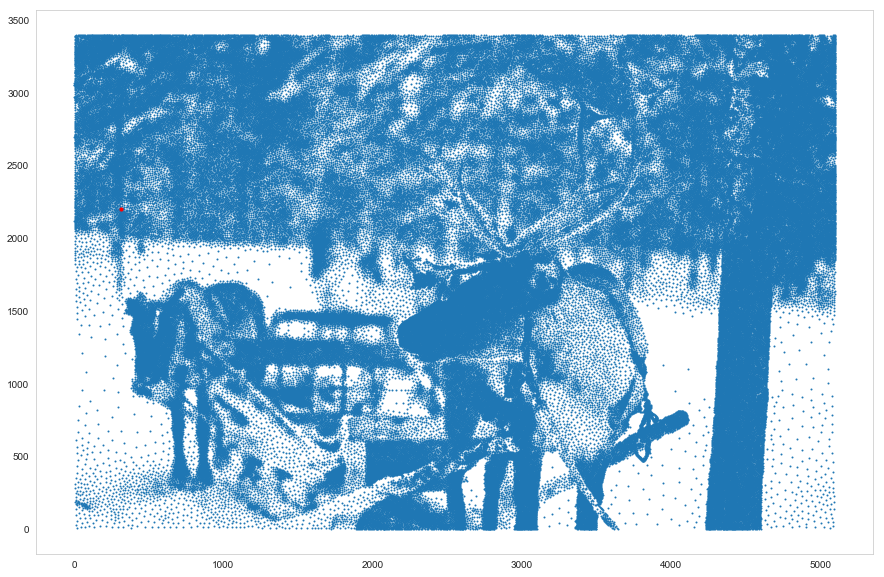

In [4]:
plt.figure(figsize=(15, 10))
plt.scatter(df.X, df.Y, s=1)
plt.scatter(df.iloc[0: 1, 1], df.iloc[0: 1, 2], s=10, c="red")
plt.grid(False)
plt.show()

In [5]:
nb_cities = max(df.CityId)
print("Number of cities to visit : ", nb_cities)

Number of cities to visit :  197768


In [6]:
df.tail()

,CityId,X,Y
197764,197764,149.828018,3134.756986
197765,197765,2615.299239,2267.979286
197766,197766,4775.889874,3103.846228
197767,197767,2994.230955,1931.764344
197768,197768,1354.764778,3218.100625


## Getting Prime Cities

In [7]:
def sieve_eratosthenes(n):
    primes = [False, False] + [True for i in range(n-1)]
    p = 2
    while (p * p <= n):
        if (primes[p] == True):
            for i in range(p * 2, n + 1, p):
                primes[i] = False
        p += 1
    return primes

In [8]:
primes = np.array(sieve_eratosthenes(nb_cities)).astype(int)
df['Prime'] = primes

In [9]:
penalization = 0.1 * (1 - primes) + 1

In [10]:
df.head()

,CityId,X,Y,Prime
0,0,316.836739,2202.340707,0
1,1,4377.405972,336.602082,0
2,2,3454.158198,2820.053011,1
3,3,4688.099298,2935.898056,1
4,4,1010.696952,3236.750989,0


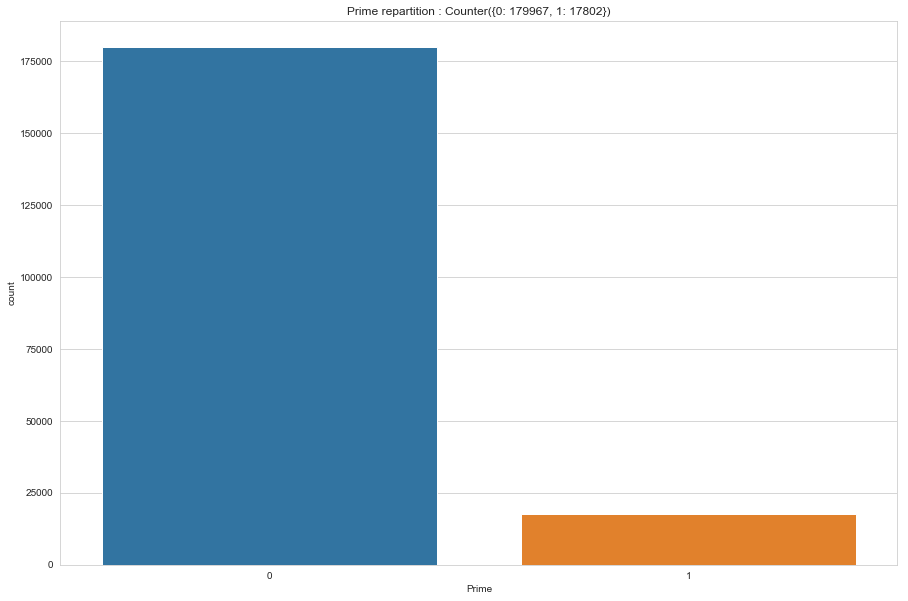

In [11]:
plt.figure(figsize=(15, 10))
sns.countplot(df.Prime)
plt.title("Prime repartition : " + str(Counter(df.Prime)))
plt.show()

Almost a tenth of the cities is prime, which is a good because we want to visit prime a prime city every 10 cities.

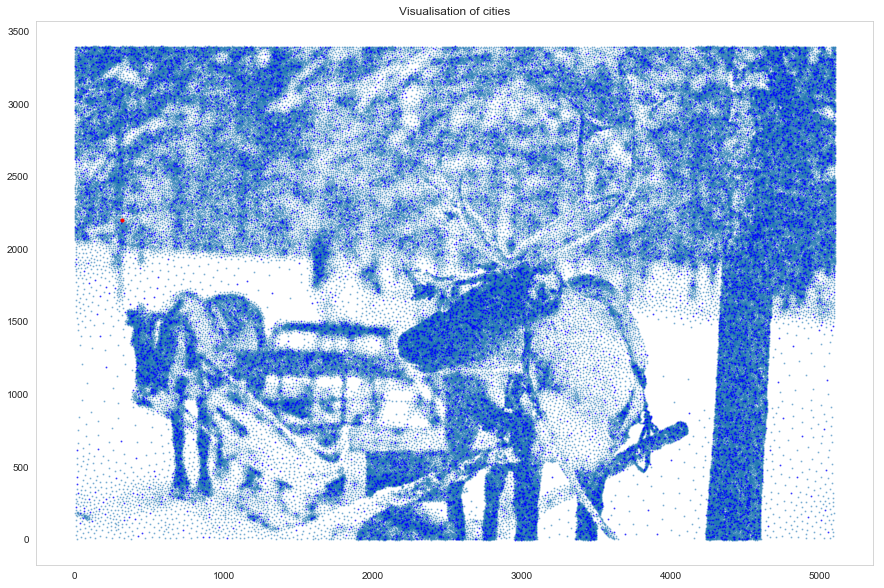

In [12]:
plt.figure(figsize=(15, 10))
plt.scatter(df[df['Prime'] == 0].X, df[df['Prime'] == 0].Y, s=1, alpha=0.4)
plt.scatter(df[df['Prime'] == 1].X, df[df['Prime'] == 1].Y, s=1, alpha=0.6, c='blue')
plt.scatter(df.iloc[0: 1, 1], df.iloc[0: 1, 2], s=10, c="red")
plt.grid(False)
plt.title('Visualisation of cities')
plt.show()

There are prime cities approximately all around the map. Which is a good thing as well.

## Now to the Algorithm

### Key functions

This first function gets the distance of all the cities to the current city.

If we decide to penalize, we multiply the distance of non-prime cities by $1.1$

In [13]:
def dist_matrix(coords, i, penalize=False):
    begin = np.array([df.X[i], df.Y[i]])[:, np.newaxis]
    mat =  coords - begin
    if penalize:
        return np.linalg.norm(mat, ord=2, axis=0) * penalization
    else:
        return np.linalg.norm(mat, ord=2, axis=0)

This one gets the closest city available

In [14]:
def get_next_city(dist, avail):
    return avail[np.argmin(dist[avail])]

### Initialization

We store city coordinates in an array, for efficiency

In [15]:
coordinates = np.array([df.X, df.Y])

We start at the north pole

In [16]:
current_city = 0 

We have all cities to visit, except the north pole

In [17]:
left_cities = np.array(df.CityId)[1:]

Our path starts with the north pole

In [18]:
path = [0]

We start at 1 the first step

In [19]:
stepNumber = 1

### Loop

In [20]:
t0 = time()

while left_cities.size > 0:
    if stepNumber % 10000 == 0: #We print the progress of the algorithm
        print(f"Time elapsed : {time() - t0} - Number of cities left : {left_cities.size}")
    # If we are at the ninth iteration (modulo 10), we may want to go to a prime city. Note that there is an approximation here: we penalize the path to the 10th city insted of 11th
    favorize_prime = (stepNumber % 10 == 9)
    # Compute the distance matrix
    distances = dist_matrix(coordinates, current_city, penalize=favorize_prime)
    # Get the closest city and go to it
    current_city = get_next_city(distances, left_cities)
    # Update the list of not visited cities
    left_cities = np.setdiff1d(left_cities, np.array([current_city]))
    # Append the city to the path
    path.append(current_city)
    # Add one step
    stepNumber += 1

Time elapsed : 36.939417123794556 - Number of cities left : 187769
Time elapsed : 71.94976902008057 - Number of cities left : 177769


KeyboardInterrupt: 

In [ ]:
print(f"Loop lasted {(time() - t0) // 60} minutes ")

#### End

Adding the north pole to our path

In [ ]:
path.append(0)

Checking that our path is of correct length

In [ ]:
print(len(path) == len(df) + 1)

### Plotting path

In [ ]:
def plot_path(path, coordinates):
    # Plot tour
    lines = [[coordinates[: ,path[i-1]], coordinates[:, path[i]]] for i in range(1, len(path)-1)]
    lc = mc.LineCollection(lines, linewidths=2)
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_aspect('equal')
    plt.grid(False)
    ax.add_collection(lc)
    ax.autoscale()

In [ ]:
plot_path(path, coordinates)

This is kinda bad, but this is a greedy algorithm so there was not much to expect.

## Results

In [ ]:
def get_score(path, coords, primes):
    score = 0
    for i in range(1, len(path)):
        begin = path[i-1]
        end = path[i]
        distance = np.linalg.norm(coords[:, end] - coords[:, begin], ord=2)
        if i%10 == 0:
            if not primes[begin]:
                distance *= 1.1
        score += distance
    return score

In [ ]:
score = get_score(path, coordinates, primes)

In [ ]:
print("Solution scored ", score)

Again, this is not very good. Let us check the influence of going back to the north pole : 

In [ ]:
print(score - get_score(path[:-1], coordinates, primes))

Ouch. Anyways, let us submit our results.

In [ ]:
submission = pd.DataFrame({"Path": path})
submission.to_csv("submission.csv", index=None)